# Create a function that receives one URL and scrape all 100 other urls connected via href

In [88]:
from utils import create_s3_connection
S3 = create_s3_connection()

2023-04-27 03:11:13 [info     ] Success connecting S3          endpoint=localhost:9010
2023-04-27 03:11:13 [info     ] Bucket at S3 already exists    bucket_name=dev-nlp-chatbot


In [1]:
pip install unidecode

Note: you may need to restart the kernel to use updated packages.


In [9]:
import re
import string
import random
import requests

from bs4 import BeautifulSoup

from unidecode import unidecode

def sanitize(text):
    text = text.lower()    
    # Remove any non-word characters from text
    text = re.sub(r'\W+', ' ', text)
    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    #Normalize
    text = unidecode(text)
    list_text = text.split()
    text = ' '.join([word for word in list_text if word.isalpha()])
    return text

def is_link_to_file(link: str):
    extensions = [
        ".pdf", ".doc", ".docx", ".ppt", ".pptx", ".xls", ".xlsx", ".txt",
        ".html", ".htm", ".css", ".js", ".xml", ".json", ".csv", ".tsv",
        ".zip", ".tar", ".gz", ".rar", ".7z", ".bz2", ".apk", ".exe",
        ".bmp", ".jpg", ".jpeg", ".png", ".gif", ".tif", ".tiff", ".svg",
        ".mp3", ".wav", ".ogg", ".flac", ".aac", ".m4a", ".mp4", ".avi",
        ".mkv", ".mov", ".wmv", ".flv", ".webm", ".srt", ".sub", ".ass",
        ".pdf", ".epub", ".mobi", ".azw", ".azw3", ".djvu", ".fb2", ".ibook"
    ]
    return any(ext in link for ext in extensions)
    
def filter_link(link: str):
    if not link:
        return None
    
    if not (link.startswith('http://') or link.startswith('https://')):
        return None
    
    filter_list = ['facebook', 'twitter', 'youtube', 'instagram', 'linkedin', 'github']
    if (any(site in link for site in filter_list)):
        return None
    
    if is_link_to_file(link):
        return None
    
    return link


def get_external_links(url):
    url = filter_link(url)
    if not url:
        return '', set([])
    
    # Send a GET request to the URL
    response = requests.get(url)

    # Parse the HTML content of the response with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all <a> tags with an href attribute that starts with 'http' or 'https'
    external_links = []
    for link in soup.find_all('a'):
        href = link.get('href')
        filtered_link = filter_link(link=href)
        if filtered_link:
            external_links.append(filtered_link)

    all_text = soup.get_text(strip=True, separator=' ')
    all_text = sanitize(all_text)
    # Return the list of external links
    return all_text, set(external_links)


def crawl(url: str):
    # First website to crawl
    all_text, links = get_external_links(url)
    destination_fpath = f"html_content/{url.replace('https://', '').replace('http://', '').strip('/')}.txt"
    S3.save_html(content=all_text, fpath=destination_fpath)
    
    unique_links = list(set(links))
    if len(unique_links) < 1:
        print('Did not find links to crawl')
        return 
    
    crawl_children(urls=unique_links, n_sites=10, depth=2)
    return
    
def crawl_children(urls: list[str], n_sites: int, depth: int):
    # Crawl N children websites until depth == 0
    if depth == 0:
        return 
    
    try:
        urls = random.sample(urls, n_sites) 
    except:
        pass
    
    print(f'Urls to download: {urls}')
    for idx,url in enumerate(urls):
        print('\nIdx: ', idx)
        all_text, links = get_external_links(url)
        destination_fpath = f"html_content/{url.replace('https://', '').replace('http://', '').strip('/')}.txt"
        S3.save_html(content=all_text, fpath=destination_fpath)
        print('\n')
        unique_links = list(set(links))
        #pprint(unique_links)
        print(f'Save content at: {destination_fpath}')
        crawl_children(urls=unique_links, n_sites=5, depth=depth-1)

In [10]:
#url = 'https://realpython.com/build-a-chatbot-python-chatterbot/'
#url = 'https://www.receiteria.com.br/receitas-de-comidas-faceis-de-fazer/'
#url = 'https://pt.wikipedia.org/wiki/Python'
url = 'https://www.techtudo.com.br/tudo-sobre/iphone-se/'
crawl(url)

Urls to download: ['https://www.techtudo.com.br/tudo-sobre/whatsapp-messenger/', 'https://www.techtudo.com.br/tudo-sobre/', 'https://www.techtudo.com.br/informatica/roteadores/', 'https://www.techtudo.com.br/jogos/jogos-de-estrategia/', 'https://forum.techtudo.com.br/tags/jogos/?utm_source=techtudo.com&utm_medium=referral&utm_campaign=site', 'https://www.techtudo.com.br/informatica/mouses/', 'https://compare.techtudo.com.br/', 'https://privacidade.globo.com/privacy-policy/', 'https://www.techtudo.com.br/termos-de-uso/', 'https://www.techtudo.com.br/softwares/']

Idx:  0


Save content at: html_content/www.techtudo.com.br/tudo-sobre/whatsapp-messenger.txt
Urls to download: ['https://www.techtudo.com.br/informatica/impressoras/', 'https://www.techtudo.com.br/noticias/2023/04/saldo-do-nubank-nao-aparece-aplicativo-tem-instabilidade-nesta-quarta-feira-edapps.ghtml#TECHTUDO-POST-TOP-24H-item,top,2aa3d32e-64bf-4414-b20c-39eff8191938', 'https://www.techtudo.com.br/tudo-sobre/intel-core-i5/', 



Save content at: html_content/www.techtudo.com.br/softwares.txt
Urls to download: ['https://www.techtudo.com.br/mobile/telefonia/', 'https://www.techtudo.com.br/tudo-sobre/whatsapp-messenger/', 'https://www.techtudo.com.br/tudo-sobre/chromecast/', 'https://www.techtudo.com.br/jogos/jogos-de-acao/jogos-de-terror/', 'https://www.techtudo.com.br/termos-de-uso/']

Idx:  0


Save content at: html_content/www.techtudo.com.br/mobile/telefonia.txt

Idx:  1


Save content at: html_content/www.techtudo.com.br/tudo-sobre/whatsapp-messenger.txt

Idx:  2


Save content at: html_content/www.techtudo.com.br/tudo-sobre/chromecast.txt

Idx:  3


Save content at: html_content/www.techtudo.com.br/jogos/jogos-de-acao/jogos-de-terror.txt

Idx:  4


Save content at: html_content/www.techtudo.com.br/termos-de-uso.txt


['br.pinterest.com/receiteria',
 'www.grupocontteudo.com.br',
 'www.receiteria.com.br',
 'www.receiteria.com.br/arroz-e-risotos',
 'www.receiteria.com.br/bebidas',
 'www.receiteria.com.br/bolos',
 'www.receiteria.com.br/carnes',
 'www.receiteria.com.br/como-fazer-leite-evaporado',
 'www.receiteria.com.br/como-fazer-pipoca-de-cinema',
 'www.receiteria.com.br/doces-e-sobremesas',
 'www.receiteria.com.br/entradas-e-petiscos',
 'www.receiteria.com.br/entrar',
 'www.receiteria.com.br/imprimir?id=142617',
 'www.receiteria.com.br/lanches-e-salgados',
 'www.receiteria.com.br/molhos-e-pates',
 'www.receiteria.com.br/paes',
 'www.receiteria.com.br/privacidade',
 'www.receiteria.com.br/receita/arroz-com-calabresa-na-pressao-facil',
 'www.receiteria.com.br/receita/batata-rustica',
 'www.receiteria.com.br/receita/biscoito-amanteigado-sem-fermento',
 'www.receiteria.com.br/receita/bisnaguinha-sem-gluten',
 'www.receiteria.com.br/receita/bolinho-de-arroz-recheado-com-queijo',
 'www.receiteria.com.br/

# Load content from S3

In [11]:
dic_texts = {}

for s3_path in S3.list_files_recursive(folder='html_content/'):
    key = s3_path.split('.txt')[0]
    value = S3.read_html(fpath='html_content/'+s3_path)
    dic_texts[key] = value
    
    
for k,v in dic_texts.items():
    print(f'Path: {k}\nContent: {v[:10]}\n')

Path: als.wikipedia.org/wiki/Python_(Programmiersprache)
Content: python pro

Path: ast.wikipedia.org/wiki/Portada
Content: wikipedia 

Path: az.wikipedia.org/wiki/Python_(proqramla%C5%9Fd%C4%B1rma_dili)
Content: python pro

Path: br.pinterest.com/receiteria
Content: receiteria

Path: ca.wikipedia.org/wiki/Python
Content: python viq

Path: ceb.wikipedia.org/wiki/Python_(programming_language)
Content: python pro

Path: centraldeajuda.globo.com
Content: central de

Path: code.google.com/p/unladen-swallow/wiki/ProjectPlan
Content: internal s

Path: commons.wikimedia.org/wiki/Special:Search/Category:Python_(programming_language)
Content: category p

Path: compare.techtudo.com.br
Content: os melhore

Path: disqus.com/?ref_noscript
Content: disqus the

Path: el.wikipedia.org/wiki/Python
Content: python bik

Path: en.wikipedia.org/wiki/Non-profit_organization
Content: nonprofit 

Path: et.wikipedia.org/wiki/Python_(programmeerimiskeel)
Content: python pro

Path: eu.wikipedia.org/wiki/Python_(

In [12]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


# Build reverse-index

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

def build_reverse_index(dic_texts: dict):
    content_from_urls = [i['content'] for i in list(dic_texts.values())]
    website_urls      = list(dic_texts.keys())
    
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(content_from_urls)

    res = {}

    for word in vectorizer.get_feature_names_out():
        j = vectorizer.vocabulary_[word]
        doc_df = {}
        
        for i in range(len(website_urls)):
            if tfidf[i,j] > 0:
                doc_df[website_urls[i]] = tfidf[i,j]
                
        res[word] = doc_df
    
    return res

reverse_index = build_reverse_index(dic_texts)

In [100]:
def search_words(list_words: list[str], rev_index):
    assert type(list_words)==list
    result = {}
    not_found = []
    
    for word in list_words:
        word = word.lower()
        if word in rev_index.keys():
            for documento in rev_index[word].keys():
                if documento not in result.keys():
                    result[documento]  = rev_index[word][documento]
                else:
                    result[documento] += rev_index[word][documento]
        else:
            not_found.append(word)
    
    if result:
        sorted_res = dict(sorted(result.items(), key=lambda x: x[1], reverse=True))
        return sorted_res, not_found
    
    return {}, not_found

search_words(list_words=['whatsapp', 'iphone', 'jogos'], rev_index=reverse_index)

({'www.techtudo.com.br/jogos': 0.753542098277008,
  'www.techtudo.com.br/jogos/jogos-educativos': 0.7363751840955143,
  'www.techtudo.com.br/tudo-sobre/iphone-14': 0.6813144134161347,
  'www.techtudo.com.br/noticias/2023/04/whatsapp-permitira-conectar-uma-so-conta-a-varios-celulares-saiba-tudo-edapps.ghtml#TECHTUDO-POST-TOP-24H-item,top,2aa3d32e-64bf-4414-b20c-39eff8191938': 0.6624822139055433,
  'www.techtudo.com.br/jogos/jogos-de-carta-e-tabuleiro': 0.636780799545059,
  'www.techtudo.com.br/jogos/jogos-de-acao/jogos-de-terror': 0.6222172356302232,
  'www.techtudo.com.br/jogos/jogos-de-estrategia': 0.6021407540590262,
  'www.techtudo.com.br/jogos/jogos-de-luta': 0.6006940967889081,
  'www.techtudo.com.br/jogos/jogos-de-acao': 0.596353837941795,
  'www.techtudo.com.br/tudo-sobre/iphone-se': 0.57682624987192,
  'www.techtudo.com.br/jogos/jogos-de-esporte': 0.5460813463957194,
  'www.techtudo.com.br/tudo-sobre/whatsapp-messenger': 0.5445521476377635,
  'www.techtudo.com.br': 0.5346914468

In [42]:
#!pip install nltk

#import nltk
#nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [83]:
from nltk.corpus import wordnet

def wn_search_word(word: str, rev_index: dict):
    best_synset, best_synset_wup = None, 0
    
    word = word.lower()
    
    synset_1 = wordnet.synsets(word, lang='por')
    if not synset_1:
        return None

    synset_1 = synset_1[0]

    for w in rev_index.keys():
        synset_2 = wordnet.synsets(w, lang='por')
        if not synset_2:
            continue
        
        synset_2 = synset_2[0]
        wup = synset_2.wup_similarity(synset_1)
        
        if wup > best_synset_wup:
            best_synset = w
            best_synset_wup = wup
    
    dic_related_urls, not_found = search_words(list_words=[best_synset], rev_index=rev_index)
    return dic_related_urls

In [89]:
wn_search_word('computador', rev_index=reverse_index, n=5)

{'www.techtudo.com.br/softwares/apps/seguranca': 0.04939434702091904,
 'www.techtudo.com.br/informatica/placas': 0.04424174702247185,
 'www.techtudo.com.br/tudo-sobre/macos': 0.03199856989548165,
 'www.techtudo.com.br/informatica/computadores': 0.026470045215058198,
 'www.techtudo.com.br/softwares/apps/produtividade': 0.024930814239905653}

# Classificador (filtro conteudo)

In [18]:
import pandas as pd
import numpy as np

df = pd.read_csv('no_theme_tweets.csv')

In [19]:
df = df[['tweet_text', 'sentiment']]
df

,tweet_text,sentiment
0,@Tixaa23 14 para eu ir :),Positivo
1,@drexalvarez O meu like eu já dei na época :),Positivo
2,Eu só queria conseguir comer alguma coisa pra ...,Positivo
3,:D que lindo dia !,Positivo
4,"@Primo_Resmungao Pq da pr jeito!!é uma ""oferta...",Positivo
...,...,...
785809,Acordar 8 horas é tão bom :),Positivo
785810,"@mayckcunha Olá, Mayck. Você já é cliente Clar...",Positivo
785811,Opa tava na merda mm e fiquei logo mais feliz ...,Positivo
785812,@andrebraga2806 Foi como a tua lealdade :),Positivo


In [20]:
transformed_df = df.copy()
transformed_df['sentiment'] = np.where(transformed_df['sentiment'] == 'Positivo', 1, 0)

In [21]:
transformed_df

,tweet_text,sentiment
0,@Tixaa23 14 para eu ir :),1
1,@drexalvarez O meu like eu já dei na época :),1
2,Eu só queria conseguir comer alguma coisa pra ...,1
3,:D que lindo dia !,1
4,"@Primo_Resmungao Pq da pr jeito!!é uma ""oferta...",1
...,...,...
785809,Acordar 8 horas é tão bom :),1
785810,"@mayckcunha Olá, Mayck. Você já é cliente Clar...",1
785811,Opa tava na merda mm e fiquei logo mais feliz ...,1
785812,@andrebraga2806 Foi como a tua lealdade :),1


In [25]:
def balance_classes(df, column_name):
    """Balance the classes of a binary column in a dataframe."""
    counts = df[column_name].value_counts()
    # Check if classes are already balanced
    if counts.min() == counts.max():
        return df
    # Identify majority and minority classes
    majority_class = counts.idxmax()
    minority_class = counts.idxmin()
    # Randomly select instances from majority class to remove
    majority_indices = df[df[column_name] == majority_class].index
    num_instances_to_remove = len(majority_indices) - counts[minority_class]
    indices_to_remove = np.random.choice(majority_indices, size=num_instances_to_remove, replace=False)
    # Remove instances from majority class
    df = df.drop(indices_to_remove)
    return df

In [9]:
import re
from unidecode import unidecode

def cleanup(text):
    punctuation = '[!-.:?;@/…|⠀_=♥️"]' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    text_s = re.sub(r"http\S+", "", text_subbed)
    ttt = re.sub(r'''((?:https?://|www\d{0,3}[.]|[a-z0-9.-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|(([^\s()<>]+|(([^\s()<>]+)))))+(?:(([^\s()<>]+|(([^\s()<>]+))))|[^\s`!()[]{};:'".,<>?«»“”‘’]))''', " ", text_s)
    return sanitize(ttt)

def sanitize(text):
    text = text.lower()    
    # Remove any non-word characters from text
    text = re.sub(r'\W+', ' ', text)
    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    #Normalize
    text = unidecode(text)
    list_text = text.split()
    text = ' '.join([word for word in list_text if word.isalpha()])
    return text

def clean_comments(df):
    df['tweet_text'] = df['tweet_text'].apply(cleanup)
    return df

cleaned_df = clean_comments(balanced_df)
cleaned_df

,tweet_text,sentiment
0,para eu ir,1
1,drexalvarez meu like eu ja dei na epoca,1
2,eu so queria conseguir comer alguma coisa pra ...,1
3,d que lindo dia,1
4,primoresmungao pq da pr jeitoe uma oferta ha a...,1
...,...,...
526209,acordar horas e tao bom,1
526210,mayckcunha ola mayck voce ja e cliente claro c...,1
526211,opa tava na merda mm fiquei logo mais feliz so...,1
526212,foi como tua lealdade,1


In [23]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# define stopwords and stemmer for Brazilian Portuguese
stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
#nltk.download('punkt')

In [24]:
def tokenize(text):
    # tokenize text into words
    tokens = word_tokenize(text, language='portuguese')
    # remove stop words and words with length less than 3
    tokens = [token for token in tokens if token.lower() not in stop_words and len(token) > 2]
    return tokens

def preprocess_text(text: str):
    tokens = tokenize(text)
    return " ".join(tokens).lower()

text = cleaned_df['tweet_text'][11]
tokens = tokenize(text)
print(f'Text: "{text}"\n')
print(f'Tokens: {tokens}\n')
print(f'Lemmatized: {lemmatize(" ".join(tokens))}\n')
print(f'Pré-processed: "{preprocess_text(text)}"')

Text: "youngsnowblood para vc e mt obg eu me sinto ate melhor agr"

Tokens: ['youngsnowblood', 'obg', 'sinto', 'ate', 'melhor', 'agr']

Lemmatized: ['Youngsnowblood', 'obg', 'sinto', 'ate', 'bom', 'agr']

Pré-processed: "youngsnowblood obg sinto ate melhor agr"


In [30]:
preprocessed_df = cleaned_df.copy()
preprocessed_df['preprocessed_text'] = preprocessed_df['tweet_text'].apply(preprocess_text)
preprocessed_df = preprocessed_df[preprocessed_df['preprocessed_text'] != '']


In [31]:
preprocessed_df

,tweet_text,sentiment,preprocessed_text
1,drexalvarez meu like eu ja dei na epoca,1,drexalvarez like dei epoca
2,eu so queria conseguir comer alguma coisa pra ...,1,queria conseguir comer alguma coisa pra poder ...
3,d que lindo dia,1,lindo dia
4,primoresmungao pq da pr jeitoe uma oferta ha a...,1,primoresmungao jeitoe oferta aproveitar
5,badwolfwagner danievedo eu entendi mas isso fo...,1,badwolfwagner danievedo entendi porque pensei ...
...,...,...,...
526209,acordar horas e tao bom,1,acordar horas tao bom
526210,mayckcunha ola mayck voce ja e cliente claro c...,1,mayckcunha ola mayck voce cliente claro caso n...
526211,opa tava na merda mm fiquei logo mais feliz so...,1,opa tava merda fiquei logo feliz causa daquilo
526212,foi como tua lealdade,1,lealdade


In [32]:
balanced_df = balance_classes(preprocessed_df, 'sentiment').reset_index(drop=True)
balanced_df

,tweet_text,sentiment,preprocessed_text
0,drexalvarez meu like eu ja dei na epoca,1,drexalvarez like dei epoca
1,eu so queria conseguir comer alguma coisa pra ...,1,queria conseguir comer alguma coisa pra poder ...
2,d que lindo dia,1,lindo dia
3,primoresmungao pq da pr jeitoe uma oferta ha a...,1,primoresmungao jeitoe oferta aproveitar
4,badwolfwagner danievedo eu entendi mas isso fo...,1,badwolfwagner danievedo entendi porque pensei ...
...,...,...,...
524947,acordar horas e tao bom,1,acordar horas tao bom
524948,mayckcunha ola mayck voce ja e cliente claro c...,1,mayckcunha ola mayck voce cliente claro caso n...
524949,opa tava na merda mm fiquei logo mais feliz so...,1,opa tava merda fiquei logo feliz causa daquilo
524950,foi como tua lealdade,1,lealdade


In [33]:
balanced_df['sentiment'].value_counts()

sentiment
1    262476
0    262476
Name: count, dtype: int64

In [85]:
ls

__pycache__/             dev-notebook.ipynb   requirements.txt
classes/                 main.py              saved_model.pkl
count_vectorizer.joblib  no_theme_tweets.csv  utils.py


In [86]:
balanced_df.to_csv('balanced_no_theme_tweets.csv', index=False)

# Train model

In [64]:
from sklearn.model_selection import train_test_split
# Split the dataset into a training set and a testing set
x_train, x_test, y_train, y_test = train_test_split(balanced_df['preprocessed_text'], balanced_df['sentiment'], test_size=0.4, random_state=42)

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(x_train)

In [56]:
# transform the documents in the training data to a document-term matrix
x_train_vectorized = vect.transform(x_train)

In [57]:
from sklearn.linear_model import LogisticRegression #, SGDClassifier
model = LogisticRegression(max_iter=1000)
model.fit(x_train_vectorized, y_train)

LogisticRegression(max_iter=1000)

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
predictions = model.predict(vect.transform(x_test))
print('AUC: ', roc_auc_score(y_test, predictions))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

AUC:  0.7715554376558982


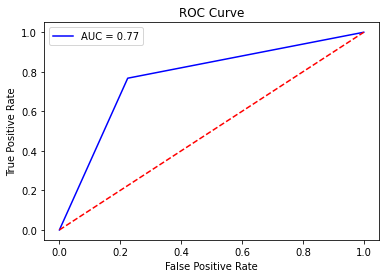

In [59]:
import matplotlib.pyplot as plt
# Plot ROC curve
plt.plot(false_positive_rate, true_positive_rate, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [62]:
for i in range(3,9):
    text = balanced_df['preprocessed_text'][i]
    is_positive = 'positive' if model.predict(vect.transform([text]))[0] else 'negative'
    print(f'{is_positive}: {text}')

positive: primoresmungao jeitoe oferta aproveitar
positive: badwolfwagner danievedo entendi porque pensei outra coisa
negative: carcinoma hepatico cancer figado deivison lutou contra doenca ano faleceu ontem tarde espero explicacao ajudado
negative: mina limpeza marido problema adicionou aqui face esquisito principio nega velha veio perguntar deve ter tomado dor viu malzao
negative: narryfools aqui espero voce melhore logo
positive: fefocaires feliz trabalhando nisso entao nao pare pessoas incomodam opiniao dao ouvido trabalho grande alcance


# Save model as pickle

In [66]:
import joblib

# Save the trained model
joblib.dump(model, 'saved_model.pkl')
joblib.dump(vect, 'count_vectorizer.joblib')


# Load and test model

In [81]:
# Load the saved model
loaded_model = joblib.load('saved_model.pkl')
loaded_vect = joblib.load('count_vectorizer.joblib')


In [83]:
loaded_model.predict_proba(loaded_vect.transform(['excelente ruim mais']))[:, 1][0]

0.667753512135506

# Use model to analyse URL content

In [96]:
def run_sentiment_anaysis(text: str, model, vect):
    sentiment = model.predict_proba(vect.transform([text]))[:, 1][0]
    # normalize from [0,1] to [-1,1]
    sentiment = 2*sentiment - 1
    return sentiment

dic_texts = {}

for s3_path in S3.list_files_recursive(folder='html_content/'):
    key = s3_path.split('.txt')[0]
    value = S3.read_html(fpath='html_content/'+s3_path)
    sentiment = run_sentiment_anaysis(text=value, model=loaded_model, vect=loaded_vect)
    dic_texts[key] = {'content': value, 'sentiment': sentiment}

In [97]:
for k,v in dic_texts.items():
    print(f"Path: {k}\nContent: {v['content'][:10]}, sentiment: {v['sentiment']}\n")

Path: als.wikipedia.org/wiki/Python_(Programmiersprache)
Content: python pro, sentiment: 0.9999999998195621

Path: ast.wikipedia.org/wiki/Portada
Content: wikipedia , sentiment: 1.0

Path: az.wikipedia.org/wiki/Python_(proqramla%C5%9Fd%C4%B1rma_dili)
Content: python pro, sentiment: 1.0

Path: br.pinterest.com/receiteria
Content: receiteria, sentiment: 0.9999973481767397

Path: ca.wikipedia.org/wiki/Python
Content: python viq, sentiment: 1.0

Path: ceb.wikipedia.org/wiki/Python_(programming_language)
Content: python pro, sentiment: 0.9993479283277646

Path: centraldeajuda.globo.com
Content: central de, sentiment: -0.5286435964425877

Path: code.google.com/p/unladen-swallow/wiki/ProjectPlan
Content: internal s, sentiment: -0.490566591140961

Path: commons.wikimedia.org/wiki/Special:Search/Category:Python_(programming_language)
Content: category p, sentiment: 1.0

Path: compare.techtudo.com.br
Content: os melhore, sentiment: 1.0

Path: disqus.com/?ref_noscript
Content: disqus the, sentime

In [102]:
dic_texts

{'als.wikipedia.org/wiki/Python_(Programmiersprache)': {'content': 'python programmiersprooch alemannische wikipedia zum inhalt springen hauptmenu hauptmenu in die seitenleiste verschieben verbergen navigation houptsyte gmeinschaftsportal zuefalls artikel inhaltsverzeichnis kategorie mitarbet un hilf mach mit froge kontaktsyte stammtisch artikel wo fahle letschti anderige sprachen in wikipedia befinden sich die sprachlinks am oberen rand der seite gegenuber dem artikeltitel zum anfang suech nois benutzerkonto aalege aamalde personlichi warkzug nois benutzerkonto aalege aamalde seiten fur abgemeldete benutzer weitere informationen byytrag diskussionssyte vun derre ip inhaltsverzeichnis in die seitenleiste verschieben verbergen anfang bispiil weblink inhaltsverzeichnis umschalten inhaltsverzeichnis umschalten python programmiersprooch sproche afrikaans aragones asm y asturianu toerkhjh basa bali belaruskaia bh jp r b l brezhoneg bosanski catala cebuano khwrdy cestina cymraeg dansk deutsc

In [120]:
dic_related_websites = search_words(list_words=['receita', 'carne'], rev_index=reverse_index)[0]

threshold = 0.3
filtered_websites = {k: v for k,v in dic_related_websites.items() if dic_texts.get(k) and dic_texts.get(k)['sentiment'] > threshold}

In [121]:
limit_result = 10
list(filtered_websites.keys())[:limit_result]

['www.receiteria.com.br/receitas-de-comidas-faceis-de-fazer',
 'www.receiteria.com.br/receitas-faceis',
 'www.receiteria.com.br/receitas-de-sobremesas-faceis',
 'www.receiteria.com.br/receita/quibe-frito-caseiro',
 'www.receiteria.com.br/receita/strogonoff-de-frango-simples',
 'www.receiteria.com.br/carnes',
 'www.receiteria.com.br/receita/penne-com-frango',
 'www.receiteria.com.br/receita/molho-de-shimeji',
 'www.receiteria.com.br/receita/pate-de-ricota-com-castanha-do-para',
 'www.receiteria.com.br/receita/pate-de-ervilha']

In [122]:
type(reverse_index)

dict

In [123]:
reverse_index

{'aa': {'als.wikipedia.org/wiki/Python_(Programmiersprache)': 0.024108786389323383,
  'az.wikipedia.org/wiki/Python_(proqramla%C5%9Fd%C4%B1rma_dili)': 0.00941433339962662,
  'ca.wikipedia.org/wiki/Python': 0.001207503389474934,
  'ceb.wikipedia.org/wiki/Python_(programming_language)': 0.015994468632799394,
  'commons.wikimedia.org/wiki/Special:Search/Category:Python_(programming_language)': 0.0022157152433127745,
  'el.wikipedia.org/wiki/Python': 0.0022855629935367005,
  'et.wikipedia.org/wiki/Python_(programmeerimiskeel)': 0.010946097891401434,
  'eu.wikipedia.org/wiki/Python_(informatika)': 0.003100692601182853,
  'fa.wikipedia.org/wiki/%D9%BE%D8%A7%DB%8C%D8%AA%D9%88%D9%86_(%D8%B2%D8%A8%D8%A7%D9%86_%D8%A8%D8%B1%D9%86%D8%A7%D9%85%D9%87%E2%80%8C%D9%86%D9%88%DB%8C%D8%B3%DB%8C)': 0.0020552686079480112,
  'jbo.wikipedia.org/wiki/paiton': 0.02448395003471487,
  'km.wikipedia.org/wiki/%E1%9E%95%E1%9E%B6%E1%9E%99%E1%9E%90%E1%9E%BB%E1%9E%93': 0.007545262620500175,
  'mr.wikipedia.org/wiki/%E0

In [127]:
import json


def save_dict(dic: dict, out_path: str):
    # Dump the dictionary to a JSON file
    with open(out_path, 'w') as f:
        json.dump(dic, f)
    
def load_dict(path: str):
    # Load the JSON file back into a dictionary
    with open(path, 'r') as f:
        dic = json.load(f)
    
    return dic

In [128]:
save_dict(reverse_index, 'reverse_index.json')

In [129]:
loaded_reverse_index = load_dict('reverse_index.json')